In [1]:
import matplotlib.pyplot as plt
import numpy as np


from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

In [2]:
# Define standard matrices.
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Define control parameters.
duration = 1e-6  # s

# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# Create a random unknown operator.
rng = np.random.default_rng(seed=10)
phi = rng.uniform(-np.pi, np.pi)
u = rng.uniform(-1, 1)
Q_unknown = (
    u * sigma_z + np.sqrt(1 - u ** 2) * (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
) / 4


def run_experiments(omegas):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity plus
    a Gaussian error.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """
    # Create the graph with the dynamics of the system.
    with qctrl.create_graph() as graph:
        signal = qctrl.operations.pwc_signal(values=omegas, duration=duration)

        hamiltonian = qctrl.operations.pwc_operator(
            signal=signal,
            operator=0.5 * (sigma_x + Q_unknown),
        )

        qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            target_operator=qctrl.operations.target(operator=sigma_x),
            name="infidelities",
        )

    # Run the simulation.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["infidelities"],
    )

    # Add error to the measurement.
    error_values = rng.normal(loc=0, scale=sigma, size=len(omegas))
    infidelities = result.output["infidelities"]["value"] + error_values

    # Return only infidelities between 0 and 1.
    return np.clip(infidelities, 0, 1)



In [3]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 10

# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [4]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5,
    upper_bound=1e5,
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration,
    upper_bound=5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)



Best infidelity after 0 BOULDER OPAL optimization steps: 0.10028633187622513


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Best infidelity after 1 BOULDER OPAL optimization step: 0.05410177428273324


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Best infidelity after 2 BOULDER OPAL optimization steps: 0.05410177428273324


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Best infidelity after 3 BOULDER OPAL optimization steps: 0.03588406627341298


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Best infidelity after 4 BOULDER OPAL optimization steps: 0.03588406627341298


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 7s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Best infidelity after 5 BOULDER OPAL optimization steps: 0.03588406627341298


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 7s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.
Infidelity: 0.0195805238032383


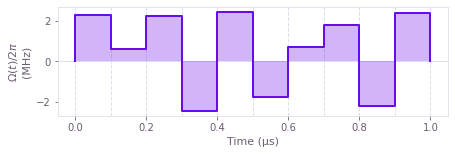

In [5]:
c_controls=[]
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3 * sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, experiment_results)
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer,
        results=results,
        test_point_count=test_point_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls
    c_controls.append({"duration": duration, "values": best_controls})

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)



In [6]:
c_controls

[{'duration': 1e-06,
  'values': array([ -4853054.24506143,   6024400.25836128,  15345609.12420198,
           6338531.85848864,  12776409.05241747, -15288405.1827572 ,
           3258380.41340426, -12650480.71988917,  11702578.1162624 ,
          14459109.59754295])},
 {'duration': 1e-06,
  'values': array([ -4853054.24506143,   6024400.25836128,  15345609.12420198,
           6338531.85848864,  12776409.05241747, -15288405.1827572 ,
           3258380.41340426, -12650480.71988917,  11702578.1162624 ,
          14459109.59754295])},
 {'duration': 1e-06,
  'values': array([-2955474.59625264, -5072162.03154982,  5386538.83221494,
         13017565.54212119, 14521048.7571335 , -6381265.21028157,
          3245887.82422187, -9028246.33513067, 12221228.75107917,
         13732749.41278581])},
 {'duration': 1e-06,
  'values': array([-2955474.59625264, -5072162.03154982,  5386538.83221494,
         13017565.54212119, 14521048.7571335 , -6381265.21028157,
          3245887.82422187, -9028246.

In [7]:
b_c = (c_controls)

for i in range(len(c_controls)):
    b_c[i]['values']= (c_controls[i]['values']/sum(c_controls[i]['values']))


In [8]:
c_controls

[{'duration': 1e-06,
  'values': array([-0.13076399,  0.16232553,  0.41348252,  0.17078971,  0.34425625,
         -0.41194118,  0.08779602, -0.34086315,  0.31532222,  0.38959607])},
 {'duration': 1e-06,
  'values': array([-0.13076399,  0.16232553,  0.41348252,  0.17078971,  0.34425625,
         -0.41194118,  0.08779602, -0.34086315,  0.31532222,  0.38959607])},
 {'duration': 1e-06,
  'values': array([-0.0763928 , -0.13110471,  0.13923069,  0.33647666,  0.37533853,
         -0.16494227,  0.08389937, -0.23336116,  0.31589303,  0.35496266])},
 {'duration': 1e-06,
  'values': array([-0.0763928 , -0.13110471,  0.13923069,  0.33647666,  0.37533853,
         -0.16494227,  0.08389937, -0.23336116,  0.31589303,  0.35496266])},
 {'duration': 1e-06,
  'values': array([-0.0763928 , -0.13110471,  0.13923069,  0.33647666,  0.37533853,
         -0.16494227,  0.08389937, -0.23336116,  0.31589303,  0.35496266])},
 {'duration': 1e-06,
  'values': array([ 0.37591278,  0.10497399,  0.36947817, -0.40231709

In [9]:
shot_count = 1024

In [10]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=b_c,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [11]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [12]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
control #1: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
control #2: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
control #3: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
control #4: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
control #5: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00


In [13]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.98, P(|1>) = 0.02, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00
